# Multiclass Classification using ANN

Implementatiton of multiclass classification with ANN using Pytorch on Iris dataset

## Necessary Imports

Import the following libraries

* torch             - Pytorch library
* torch.nn          - Pytorch's neural network class
* torch.nn.functional - Pytorch's neural network functional API
* numpy             - Library for performing linear algebra operations
* matplotlib        - Library to visualise data and metrics
* sklearn.metrics.train_test_split - To split dataset into training set and testing set
* pandas - Library to read and perform operations with csv, excel sheets, etc.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Check if your Pytorch is GPU & CUDA enabled (only for NVIDIA GPUs)

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 1050 Ti'

## Load the dataset

Load teh iris.csv file using Pandas library and analyze the data by visualizing

In [4]:
df = pd.read_csv("dataset/iris.csv")

In [5]:
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


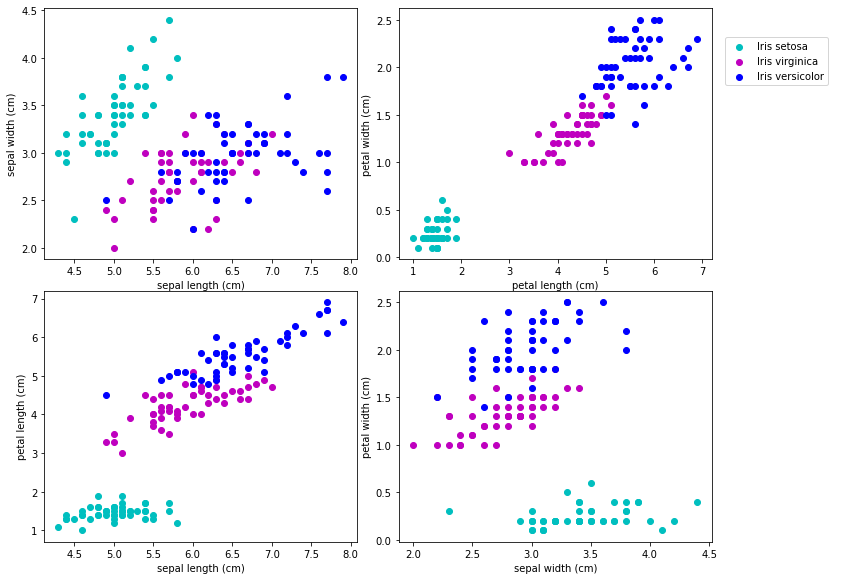

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['c', 'm', 'b']
labels = ['Iris setosa', 'Iris virginica', 'Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

## Prepare the data

* Use the features **speal length, sepal width, petal length, petal width** as input features to predict the output feature **target**

* Split the data into Training set and testing set (80% for training, 20% for testing)

* Convert the numpy arrays into Pytorch tensors

In [7]:
data = df.drop(['target'], axis=1).values
labels = df['target'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=51)

In [9]:
X_train, X_test = torch.FloatTensor(X_train).cuda(), torch.FloatTensor(X_test).cuda()
y_train, y_test = torch.LongTensor(y_train).cuda(), torch.LongTensor(y_test).cuda()

## Build the ANN model

* Subclass torch.nn 's Module.
* Call the super class's initializer.
* Create an input layer using **nn.Linear(in_features, hidden_units_1)** which implements a fully-connected / dense layer.
* Create a hidden layer using **nn.Linear(hidden_units_1, hidden_units_2)** which implements another fully-connected / dense layer.
* Create an output layer using **nn.Linear(hidden_units_2, out_features)** which implements fully-connected / dense layer as our output layer.
* Create a method named forward which will perform single forward pass to predict **y_hat** value given an input X
* Apply **Leaky ReLU actiavtion** function over input layer and hidden layer, return the value from output layer

In [10]:
class ANN(nn.Module):
    def __init__(self, in_feat=4, hidden_units_1=8, hidden_units_2=4, out_feat=3):
        super().__init__()
        self.input_layer = nn.Linear(in_feat, hidden_units_1)
        self.hidden_layer = nn.Linear(hidden_units_1, hidden_units_2)
        self.output_layer = nn.Linear(hidden_units_2, out_feat)
    
    def forward(self, X):
        x = F.leaky_relu(self.input_layer(X), negative_slope=0.3)
        x = F.leaky_relu(self.hidden_layer(x), negative_slope=0.3)
        x = self.output_layer(x)
        return x

Instantiate our ANN model

In [11]:
model = ANN().cuda()

Set the following training configuration:

* Use CrossEntropy loss as cost / loss fucntion
* Use Adam optimizer with learning rate preferrably 0.01
* Number of training iterations as epochs
* Two empty lists to store our losses and validation losses for every single iteration, which we will use to visualize later

In [12]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 300
losses = []
val_losses = []

Train the model

In [13]:
for e in range(epochs):
    # perform one forward pass
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    losses.append(loss)
    
    with torch.no_grad():
        y_valid = model.forward(X_test)
        val_loss = criterion(y_valid, y_test)
        val_losses.append(val_loss)
        
    # display training metrics
    if (e % 50 == 0) or e==0 or e==(epochs-1):
        print("Epoch {}".format(e+1))
        print("Loss: {:.4f} | Validation Loss: {:.4f} ".format(loss, val_loss))
    
    # back propagation
    optim.zero_grad()
    loss.backward()
    optim.step()

Epoch 1
Loss: 1.2757 | Validation Loss: 1.3332 
Epoch 51
Loss: 0.3692 | Validation Loss: 0.3241 
Epoch 101
Loss: 0.0679 | Validation Loss: 0.0876 
Epoch 151
Loss: 0.0511 | Validation Loss: 0.0689 
Epoch 201
Loss: 0.0465 | Validation Loss: 0.0676 
Epoch 251
Loss: 0.0437 | Validation Loss: 0.0689 
Epoch 300
Loss: 0.0415 | Validation Loss: 0.0713 


## Evaluation

* Plot the loss and validation loss and check if they converge
* Analyse for overfit/underfit

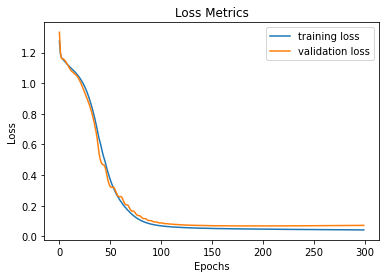

In [14]:
plt.plot(range(epochs), losses, label='training loss')
plt.plot(range(epochs), val_losses, label='validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [15]:
num_correct = 0
pred = []

with torch.no_grad():
    for index, data in enumerate(X_test):
        y_hat = model.forward(data)
        pred.append(y_hat)
        if y_hat.argmax().item() == y_test[index]:
            num_correct += 1            

In [16]:
print("Number of samples correctly classified: {}\nNumber of samples wrongly classified: {}".format(num_correct, (len(y_test)-num_correct)))
print("Test Accuracy: {:.4f}".format((num_correct/len(y_test))*100))

Number of samples correctly classified: 29
Number of samples wrongly classified: 1
Test Accuracy: 96.6667


## Save the model

In [17]:
torch.save(model.state_dict(), 'iris_ANN.pt')